In [1]:
# Extract tar.gz file into multiple csv files
import tarfile
  
# open file
file = tarfile.open('forecasting_train_v1.1.tar.gz')
  
# extracting file
file.extractall('./Destination_FolderName')
  
file.close()



In [1]:
# import packages and libraries
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import pickle
from glob import glob
import itertools
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import *
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
import csv
from collections import defaultdict

# Exploratory Data Analysis

1. There are total number of 205942 csv files in the training dataset
2. General Statistics of the training dataset

    - There are total of 7753060 unique `TRACK_ID`
    - There are three categories of `OBJECT_TYPE` with their corresponding frequencies: OTHERS (155302611), AGENT (10297100), AV (10297100)
    - There are two cities in `CITY_NAME`with their corresponding frequencies: PIT (66428725), MIA (109468086)
3. Frequency Distribution of total number of timestamps for each track id
    - The frequency / Count decreases exponentially as the total number of timestamps increases. 
    - However, the frequency for bins between 45 - 50 timestamps is high
    - Data cleaning is needed to remove `TRACK_ID` with too little total timestamps, and split longer trajectories into multiple smaller one
4. Distribution of X
    - Total of 175,896,810 entries for X values
    - Since the total number is too large to display the distribution visually, we sample 1 million datapoints to plot the frequency distribution
    - There is a binomial distribution with one cluster centered at 500, and the other centered at 3000
5. Distributino of Y
    - Total of 175,896,810 entries for Y values
    - Sample 1 million without replacement to plot the frequency distribution
    - The distribution is centered around 2000 with smaller frequencies for higher y value
6. There is no null value across all csv files
7. There is only one agent inside each csv file
8. There are total of 50 timestamps for each agent in each csv file

In [36]:
# 1. Count the total number of files in the folder
count = 0
# Iterate directory
for path in os.listdir('./train/data/'):
      count += 1
print('The total number of csv file is '+str(count))

The total number of csv file is 205942


In [55]:
csv_files = glob(os.path.join('./train/data/', "*.csv"))
 
# Defining the dict
objects_dict = defaultdict(lambda: 0)
cities_dict = defaultdict(lambda: 0)
agents_dict = defaultdict(lambda: 0)
timestamps_dict = defaultdict(lambda: 0)

track_count = 0
count = 0

# Merge the value of two dictionaries
def merge_dict(dict1, dict2): 
    for item in list(dict2.keys()):
        dict1[item] += dict2[item]
        
    
# Create csv files to store EDA values in case of memory issue
# And write the column names for each csv file
with open('./train/tracks.csv', 'w') as tracks, open('./train/xs.csv', 'w') as xs, open('./train/ys.csv', 'w') as ys:
    write = csv.writer(tracks)
    write.writerows(['ids', 'count'])
    
    write = csv.writer(xs)
    write.writerows(['index', 'x'])
    
    write = csv.writer(ys)
    write.writerows(['index', 'y'])
    

# Calculate General Statistics
count = 0
with open('./train/tracks.csv', 'a') as tracks, open('./train/xs.csv', 'a') as xs, open('./train/ys.csv', 'a') as ys:
    
    for f in csv_files:
        # read the csv file
        df = pd.read_csv(f)

        # Calculate null values for all csv files
        null += df.isnull().sum()
        
        # Count total number of unique track_id across all files
        # Count total number of timestamps for each unique track_id across all files, store into csv file
        track = df['TRACK_ID'].value_counts()
        track_count += track.shape[0]
        track.to_csv(tracks, header=False)

        # Count the unique object types and their frequencies
        objec = df['OBJECT_TYPE'].value_counts().to_dict()
        merge_dict(objects_dict, objec)
        
        # Count the unique cities and their frequencies
        city = df['CITY_NAME'].value_counts().to_dict()
        merge_dict(cities_dict, city)
        
        # Append X values into csv file
        df['X'].to_csv(xs, header=False)
        
        # Append Y values into csv file
        df['Y'].to_csv(ys, header=False)
        
        # Count number of AGENT in a csv file
        agent_df = df.loc[df['OBJECT_TYPE'] == 'AGENT'].groupby('TRACK_ID')['X'].count()
        agent = agent_df.shape[0]
        agents_dict[agent] += 1

        # Count number of timestamps for each AGENT in a csv file
        for item in agent_df:
            timestamps_dict[item] += 1
        

        # Track progress
        if count % 1000 == 0: 
            print(count)
        count += 1


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [39]:
# 2a. Total number of track_id
print('There are total of '+str(track_count)+' unique track id')

There are total of 7753060 unique track id


In [14]:
# 2b. Object Type Summary
objects_dict

defaultdict(<function __main__.<lambda>()>,
            {'OTHERS': 155302611, 'AGENT': 10297100, 'AV': 10297100})

In [15]:
# 2c. City Summary
cities_dict

defaultdict(<function __main__.<lambda>()>,
            {'PIT': 66428725, 'MIA': 109468086})

Text(0, 0.5, 'Frequency')

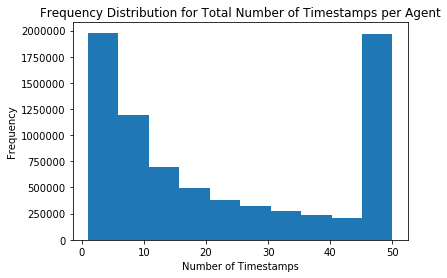

In [27]:
# 3. Frequency Distribution of Total Number of Timestamps
track_ids = pd.read_csv('./train/tracks.csv')
#track_ids.rename(columns = {'00000000-0000-0000-0000-000000070303':'ids', '50':'count'}, inplace = True)
plt.hist(list(track_ids['count']))
plt.title('Frequency Distribution for Total Number of Timestamps per Agent')
plt.xlabel('Number of Timestamps')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

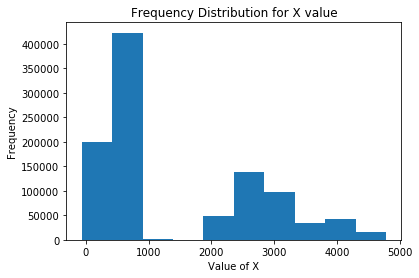

In [41]:
# 4. Distribution of X with 175896810 entries
xvalue = pd.read_csv('./train/xs.csv')
xvalue.rename(columns = {'0':'index', '2661.0156381377387':'x'}, inplace = True)
xsample = xvalue.sample(n = 1000000, replace = False)
ax = xsample['x'].plot(kind='hist')
ax.set_title('Frequency Distribution for X value')
ax.set_xlabel('Value of X')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

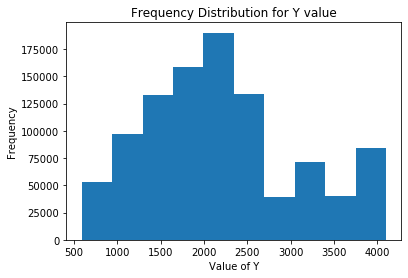

In [4]:
# 5. Distribution of Y with 175896810 entries
yvalue = pd.read_csv('./train/ys.csv')
yvalue.rename(columns = {'0':'index', '1145.753051913686':'y'}, inplace = True)
ysample = yvalue.sample(n = 1000000, replace = False)
ax = ysample['y'].plot(kind='hist')
ax.set_title('Frequency Distribution for Y value')
ax.set_xlabel('Value of Y')
ax.set_ylabel('Frequency')

In [10]:
# 6. Null Value
null

TIMESTAMP      0
TRACK_ID       0
OBJECT_TYPE    0
X              0
Y              0
CITY_NAME      0
dtype: int64

In [18]:
# 7. Number of Agent in a csv file
agents_dict

defaultdict(<function __main__.<lambda>()>, {1: 205942})

In [19]:
# 8. Number of timestamps for each AGENT in a csv file
timestamps_dict

defaultdict(<function __main__.<lambda>()>, {50: 205942})